In [112]:
#!/usr/bin/env python3
# Set up imports and paths
import sys, os
import numpy as np
# Get the helper functions for connecting to the buffer
try:     pydir=os.path.dirname(__file__)
except:  pydir=os.getcwd()    
sigProcPath = os.path.join(os.path.abspath(pydir),'../../python/signalProc')
sys.path.append(sigProcPath)
import bufhelp
import linear
import sklearn
import preproc
import pickle

dname  ='training_data_imagined_movement-2'
cname  ='clsfr'

data_path = os.path.join(pydir, 'data') # The data folder path
data_file = data_path + '/' + dname

print("Training classifier")
if os.path.exists(os.path.join(data_path, dname)+'.pk'):
    f     =pickle.load(open(data_file+'.pk','rb'))
    data_raw  =f['data']
    events=f['events']
    hdr   =f['hdr']
# try the hdf5 file
if not 'data' in dir() and os.path.exists(dname+'.h5'):
    import h5py
    f     = h5py.File(dname+'.mat','r')
    data  =f['data']
    events=f['events']
    hdr   =f['hdr']
# try the .mat file if all else fails
if not 'data' in dir() and os.path.exists(dname+'.mat'):
    from scipy.io import loadmat
    f     = loadmat(dname+'.mat')
    data  =f['data']
    events=f['events']
    hdr   =f['hdr']



Training classifier


In [113]:

#-------------------------------------------------------------------
#  Run the standard pre-processing and analysis pipeline

# get data in correct format
data_arr = np.array(data_raw)
print(data_arr.shape)
data_t = np.transpose(data_arr)
print(data_t.shape)
fs = hdr.fSample # sample rate



(12, 750, 37)
(37, 750, 12)


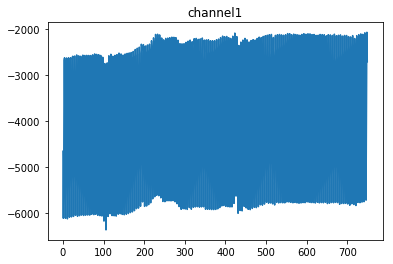

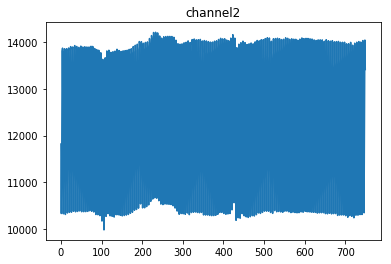

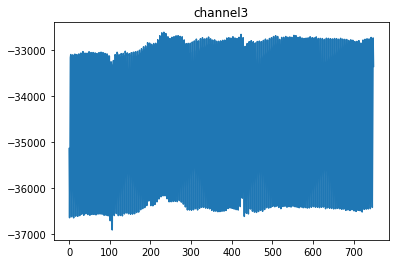

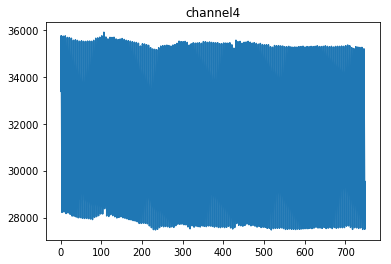

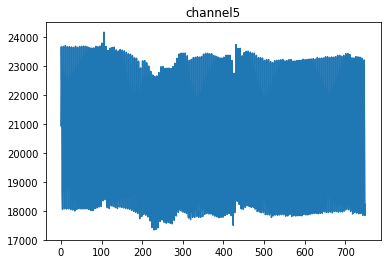

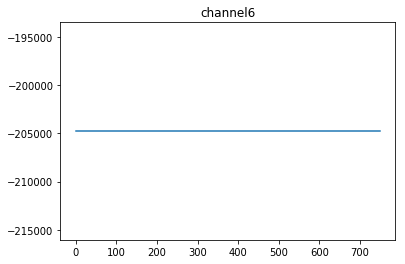

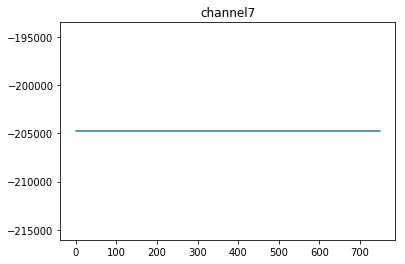

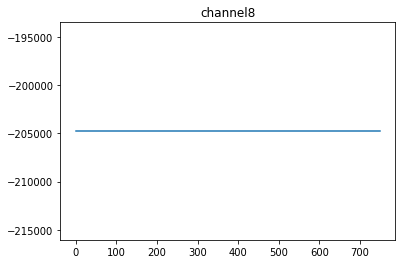

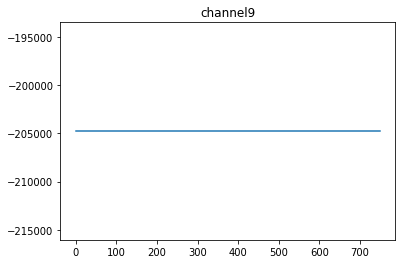

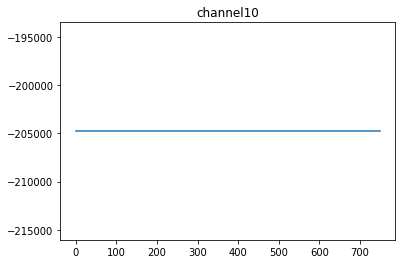

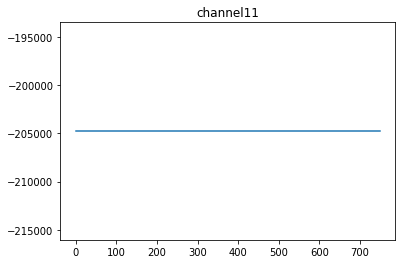

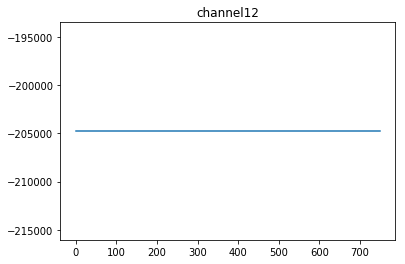

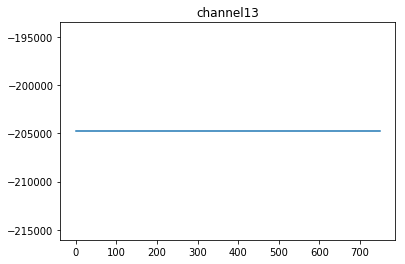

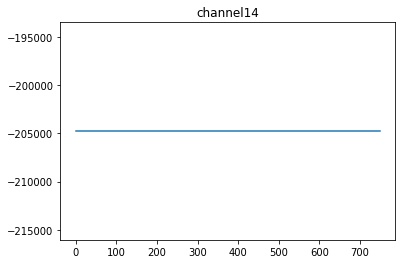

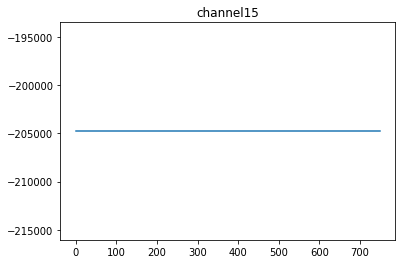

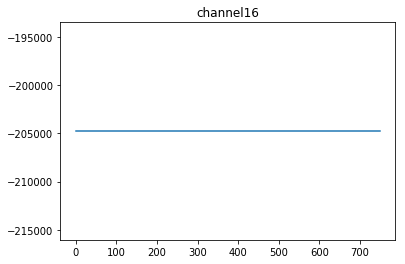

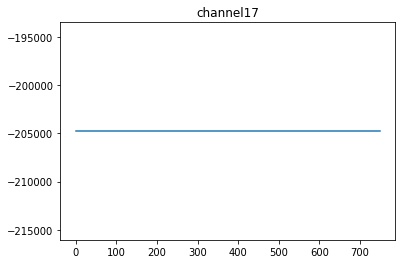

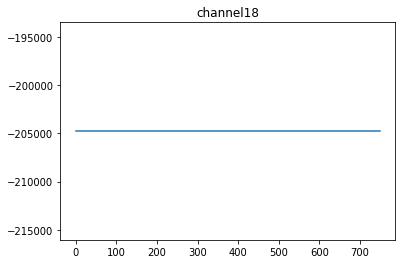

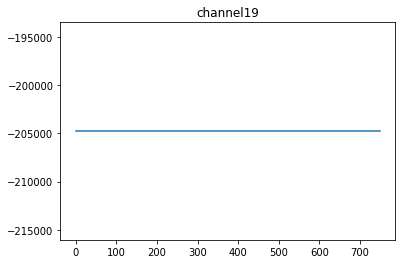

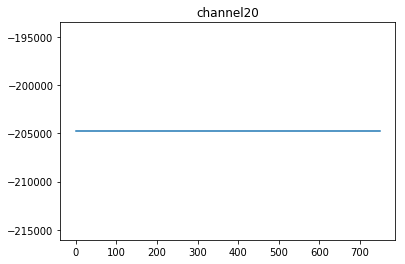

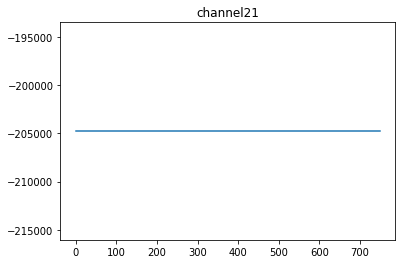

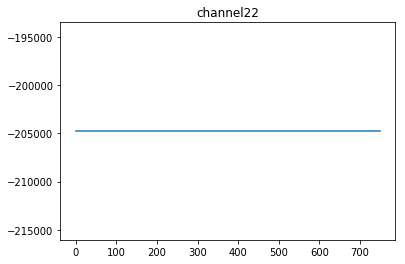

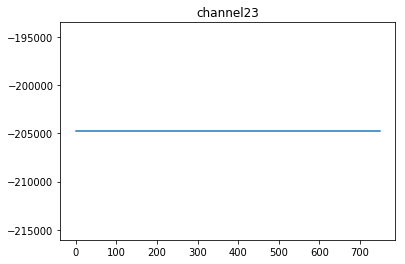

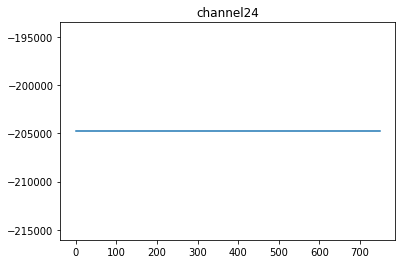

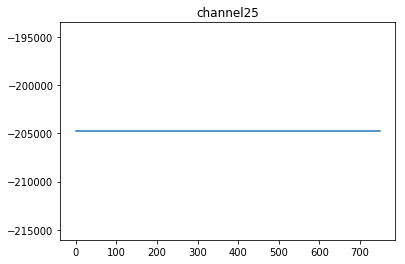

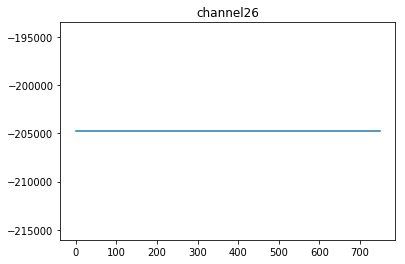

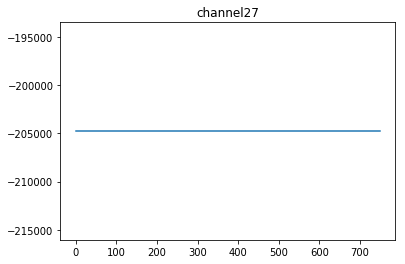

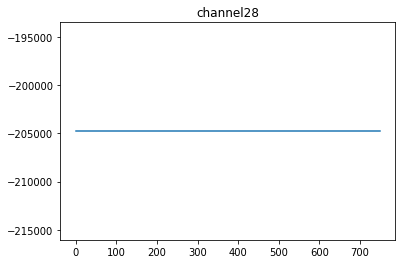

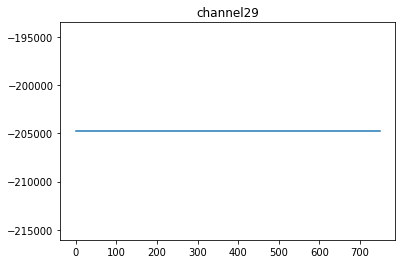

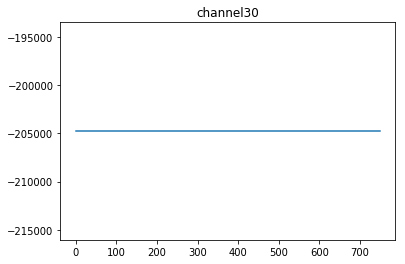

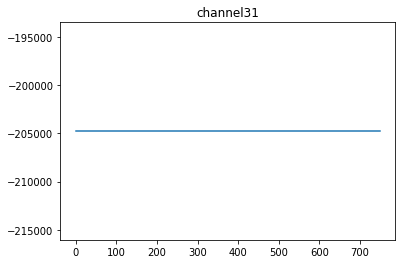

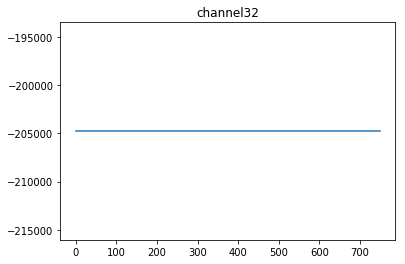

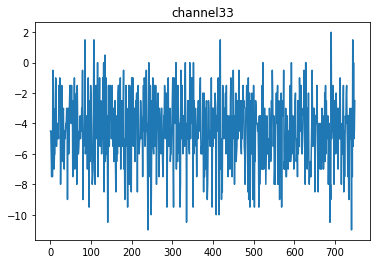

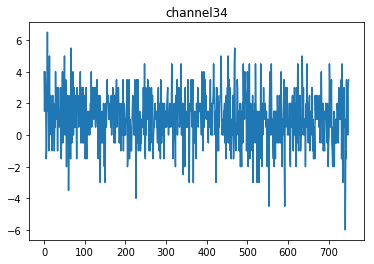

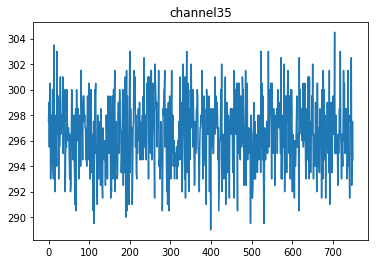

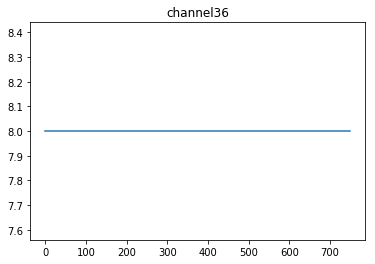

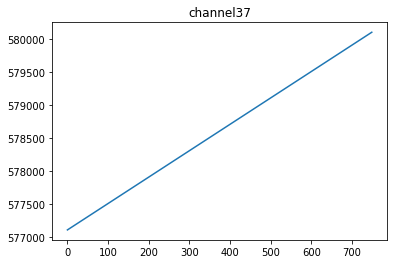

In [114]:
import matplotlib.pyplot as plt
%matplotlib inline

epoch = 0 #select epoch

for ch in range(data_t.shape[0]):
    plt.plot(data_t[ch,:,epoch])
    plt.title('channel'+str(ch+1))
    plt.show()

In [115]:
# 0: get class labels from events values
y = [e.value[0] for e in events] 
# convert to numeric labels
valuedict={} # dict to convert from event.values to numbers    
#y = np.array(y) # N.B. Only works with *NUMERIC* event values...
# get the unique values in y
valuedict = set(y)
# convert to dictionary
valuedict = { val:i for i,val in enumerate(valuedict) }
# use the dict to map from values to numbers
y    = np.array([ valuedict[val] for val in y ])

In [96]:
y

array([2, 0, 1, 0, 1, 2, 1, 0, 0, 1, 2, 2])

In [97]:
# 1: detrend
data_detr        = preproc.detrend(data_t)


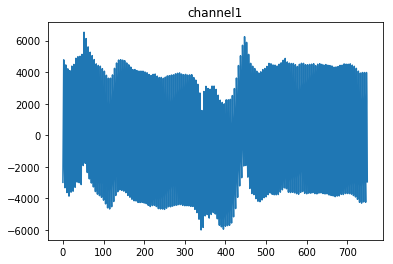

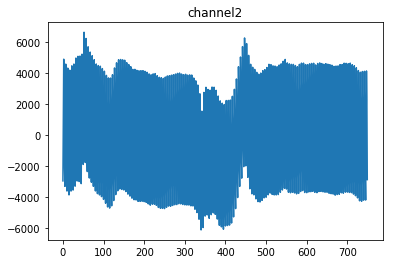

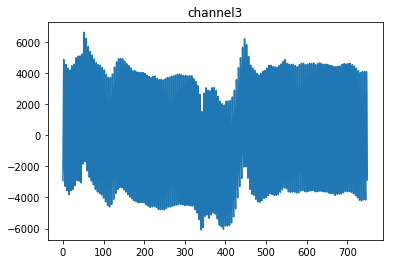

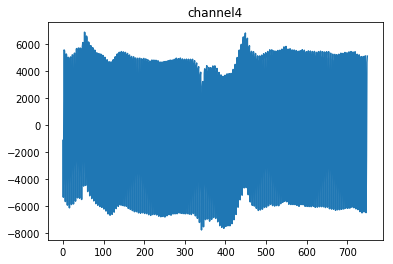

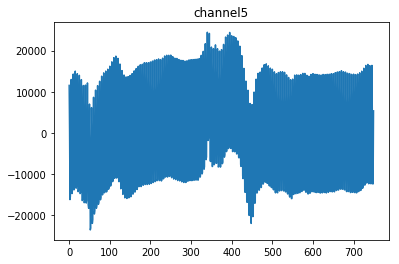

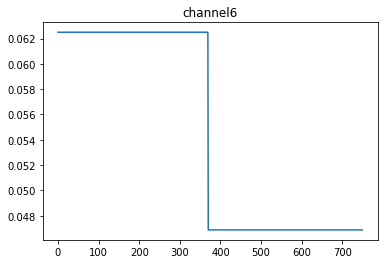

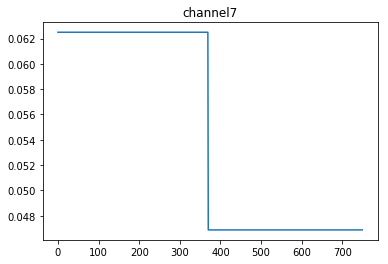

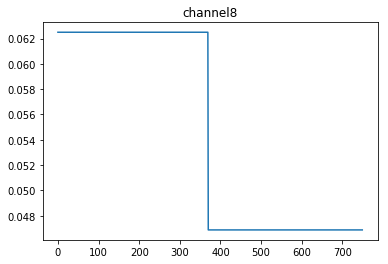

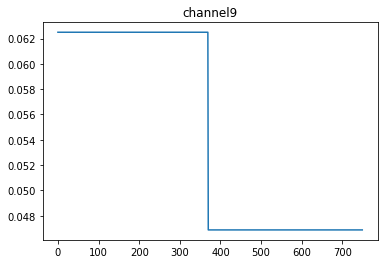

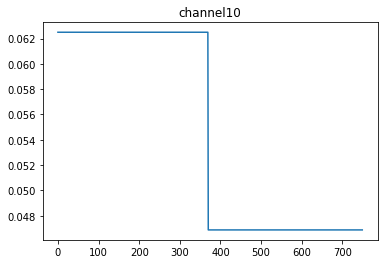

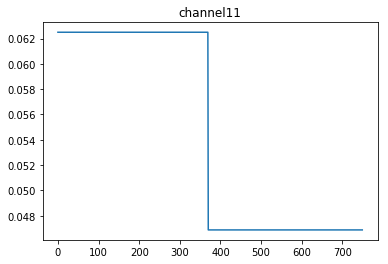

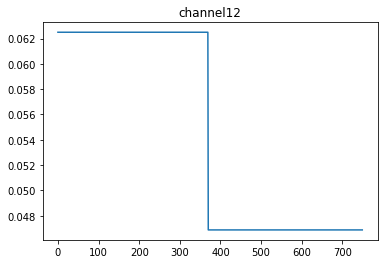

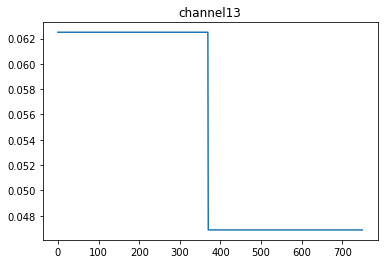

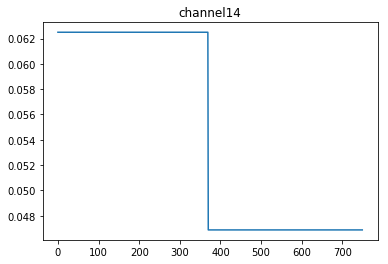

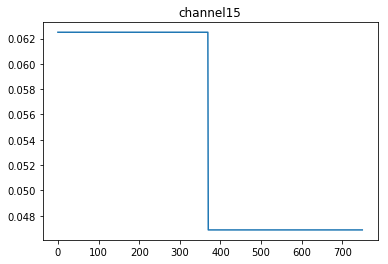

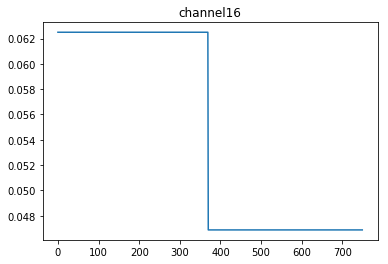

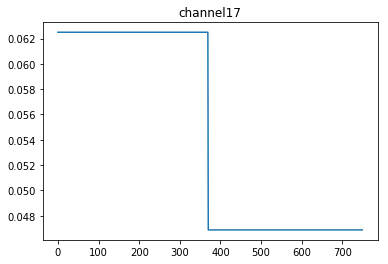

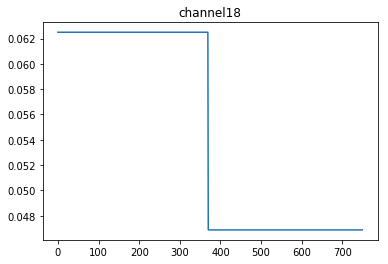

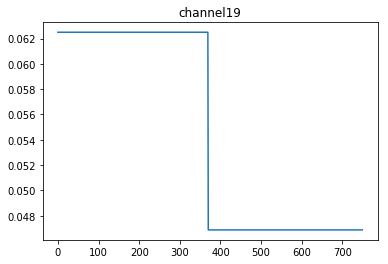

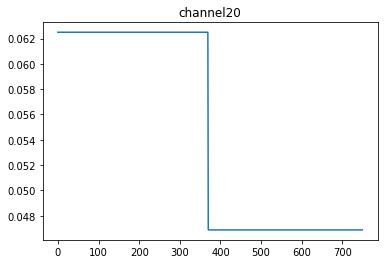

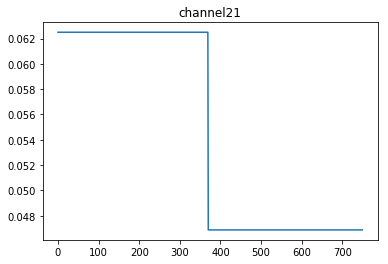

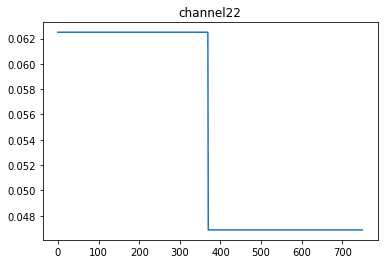

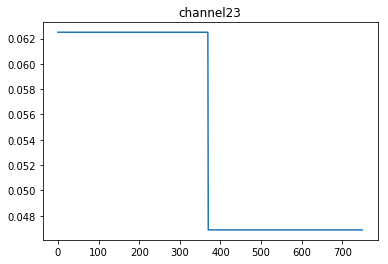

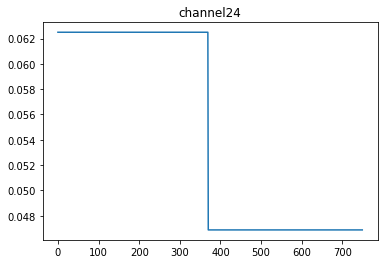

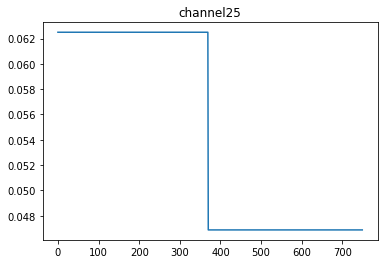

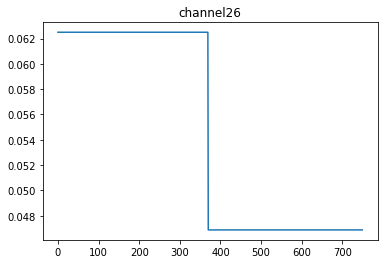

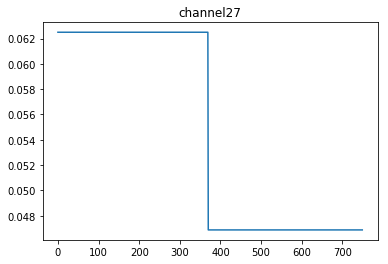

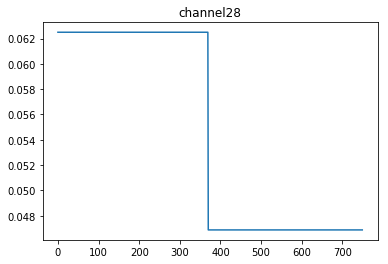

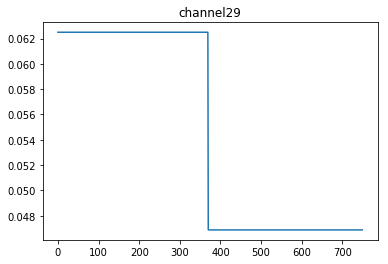

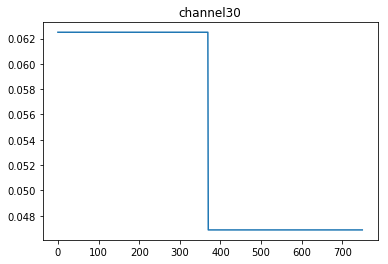

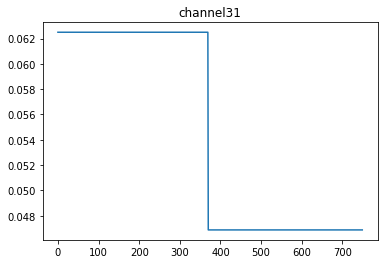

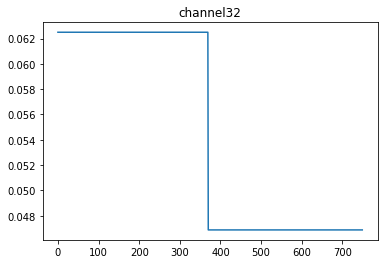

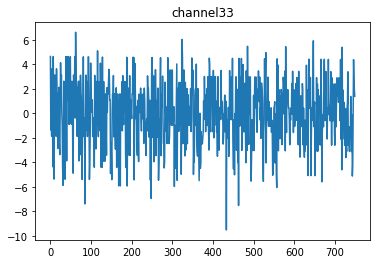

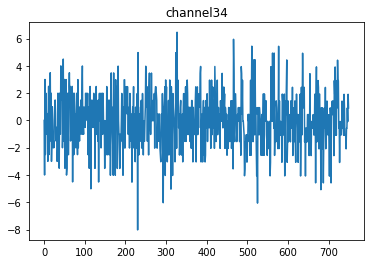

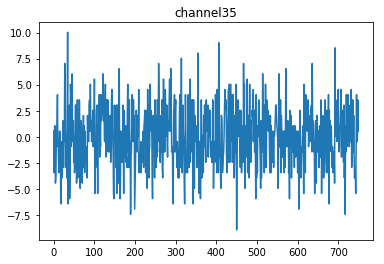

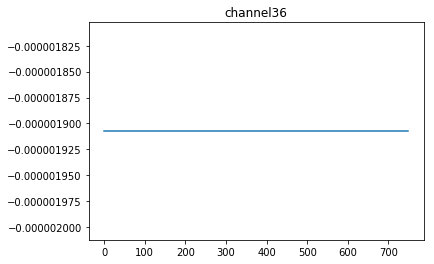

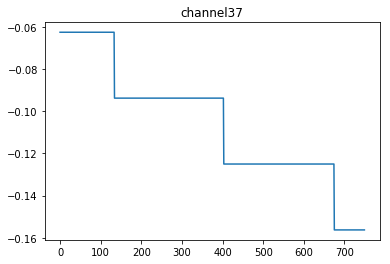

In [98]:
epoch = 0 

for ch in range(data_detr.shape[0]):
    plt.plot(data_detr[ch,:,epoch])
    plt.title('channel'+str(ch+1))
    plt.show()

In [116]:
# 2: bad-channel removal
goodch, badch = preproc.outlierdetection(data_detr);
data_goodch = data_detr[goodch,:,:];



In [117]:
len(goodch)

32

In [118]:
data_goodch.shape

(32, 750, 12)

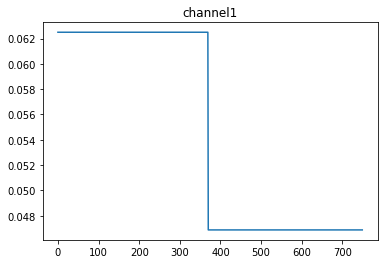

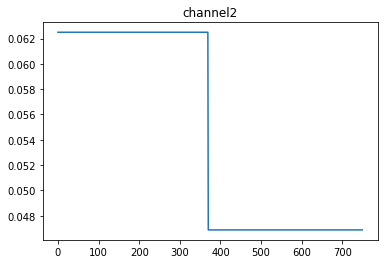

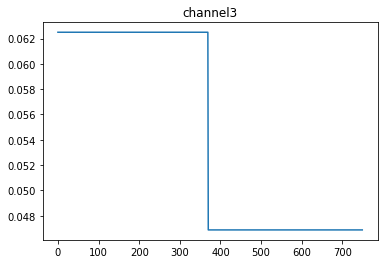

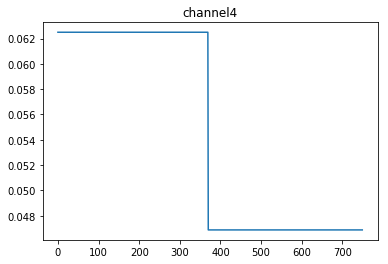

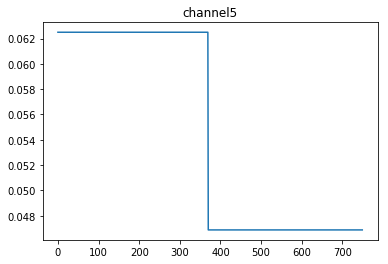

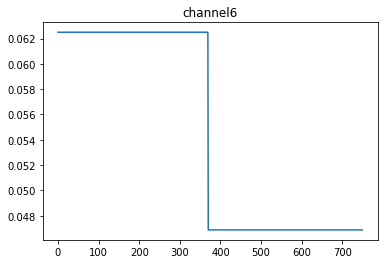

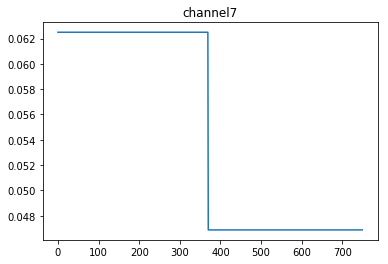

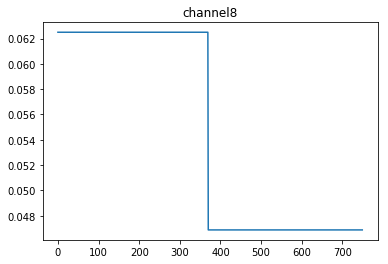

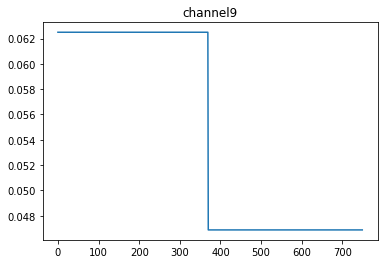

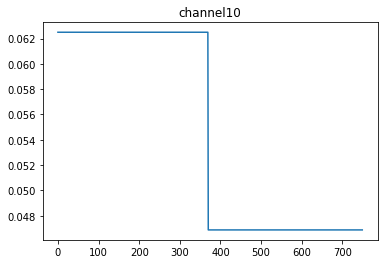

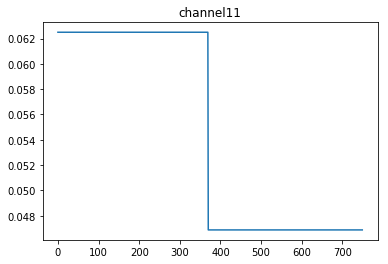

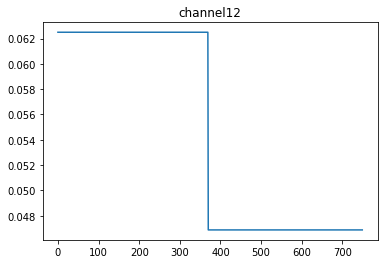

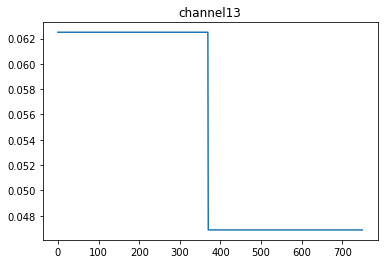

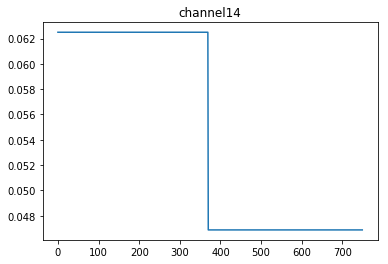

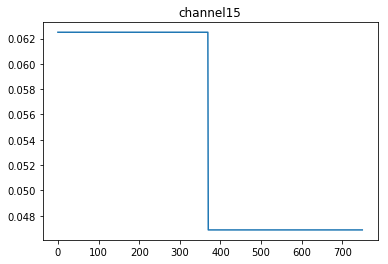

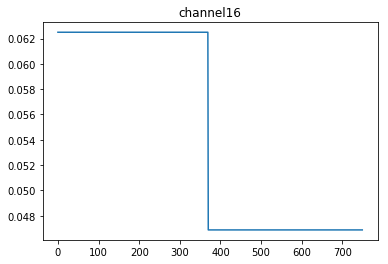

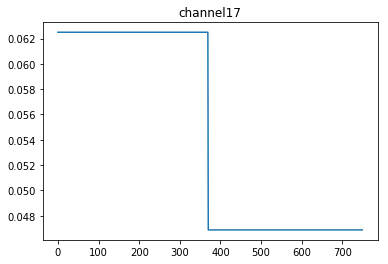

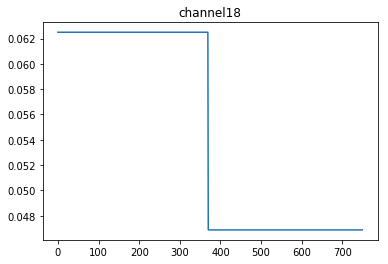

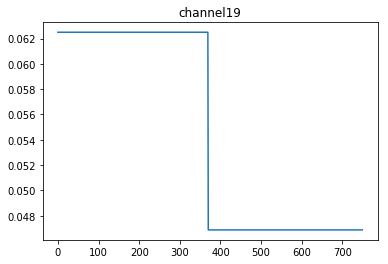

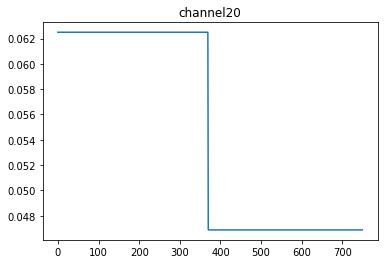

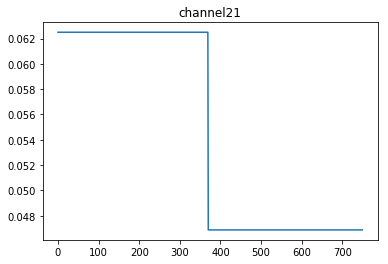

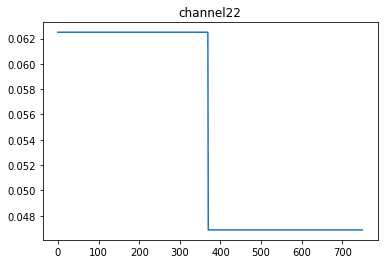

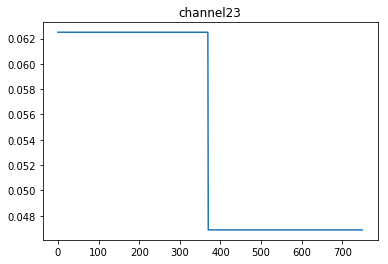

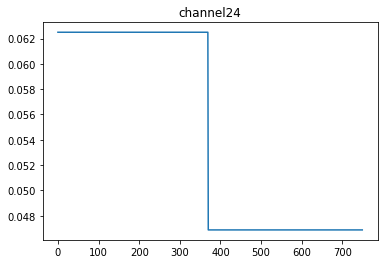

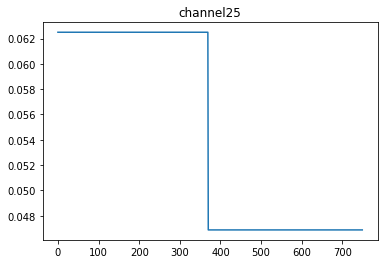

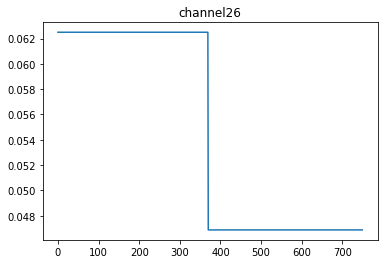

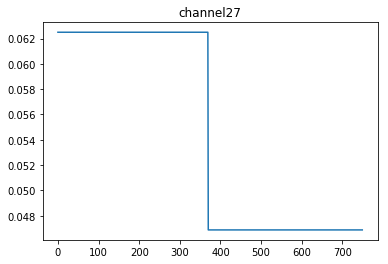

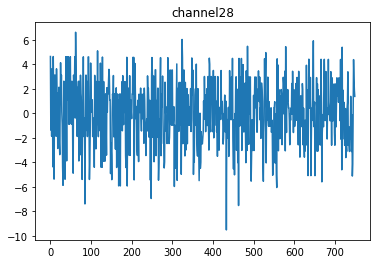

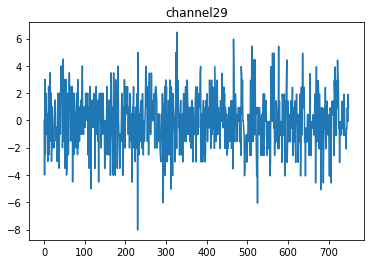

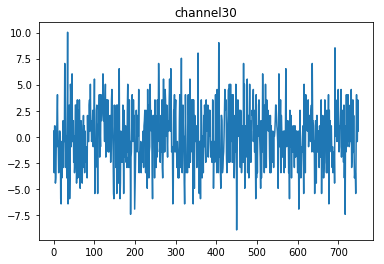

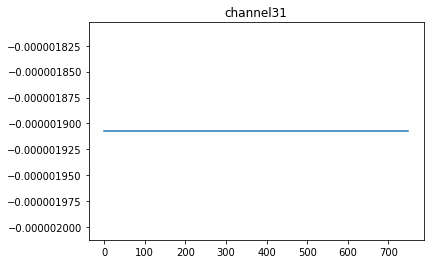

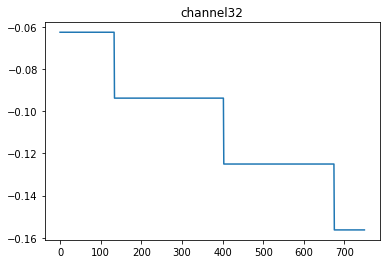

In [119]:
epoch = 0 

for ch in range(data_goodch.shape[0]):
    plt.plot(data_goodch[ch,:,epoch])
    plt.title('channel'+str(ch+1))
    plt.show()

In [103]:
# 3: apply spatial filter
spatialfilter='car'
data_sf        = preproc.spatialfilter(data_goodch,type=spatialfilter)


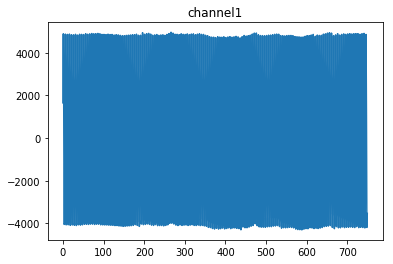

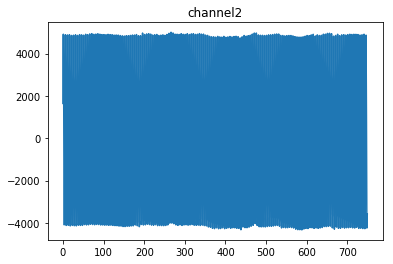

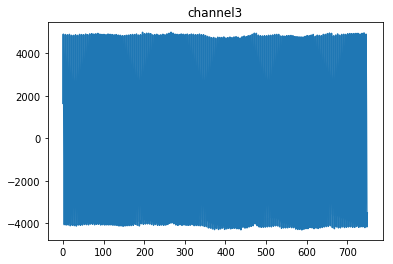

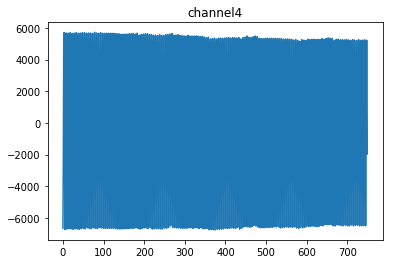

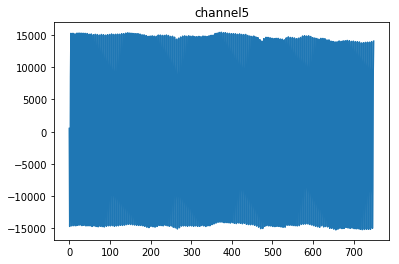

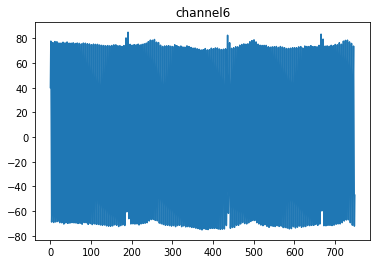

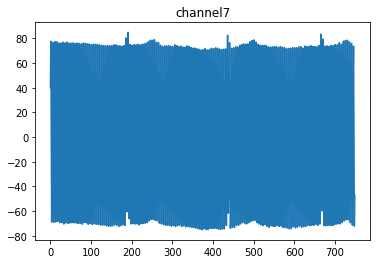

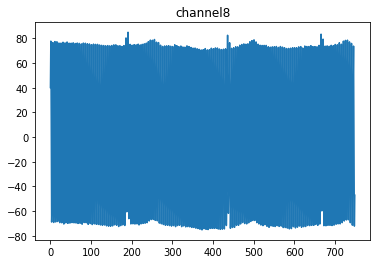

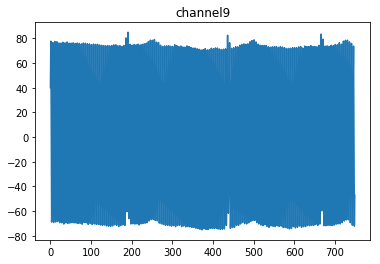

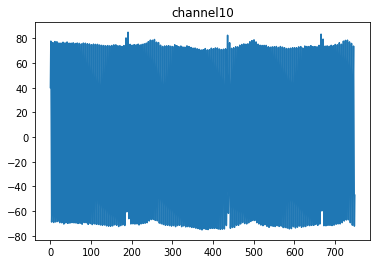

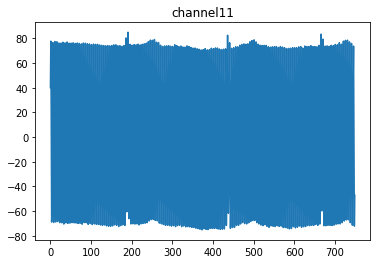

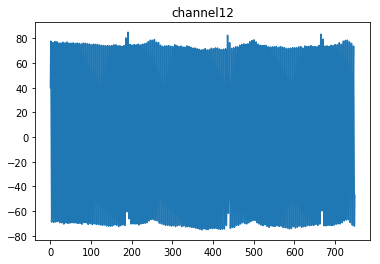

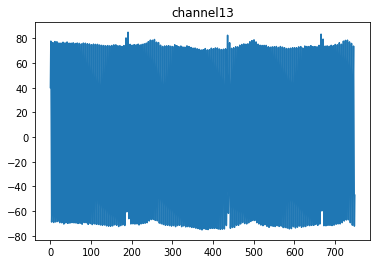

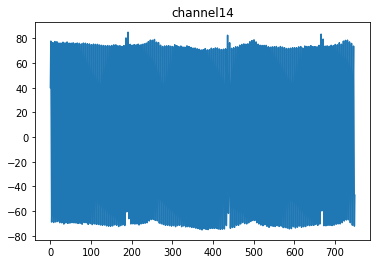

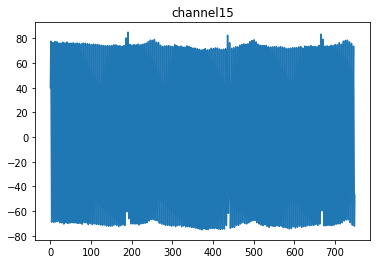

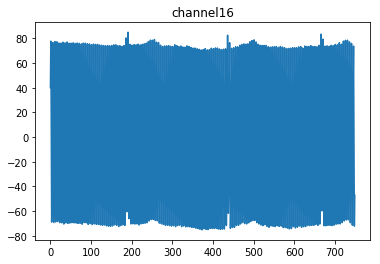

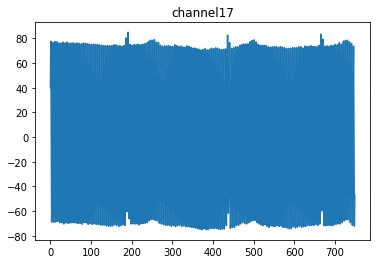

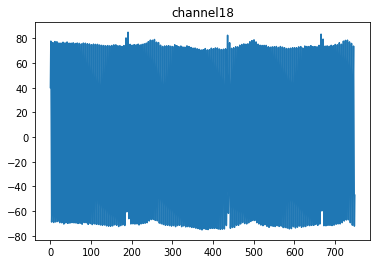

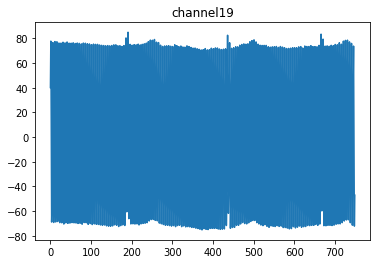

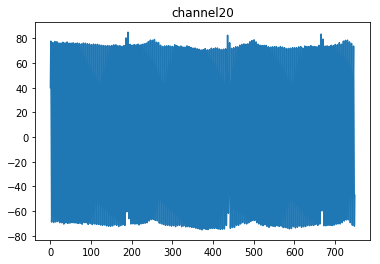

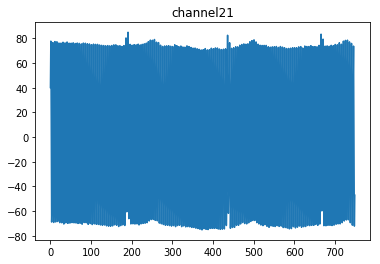

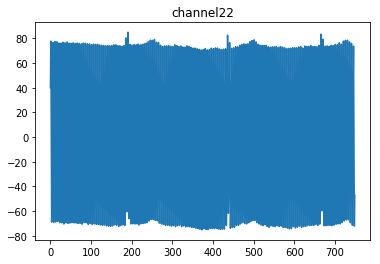

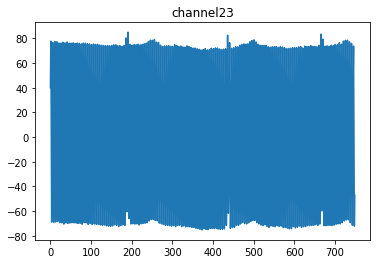

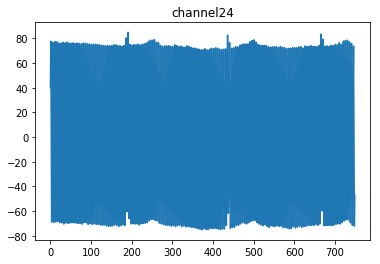

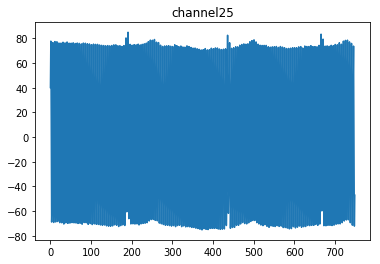

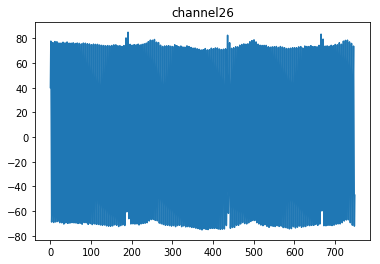

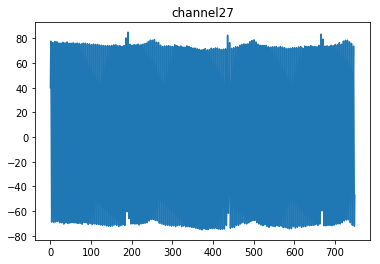

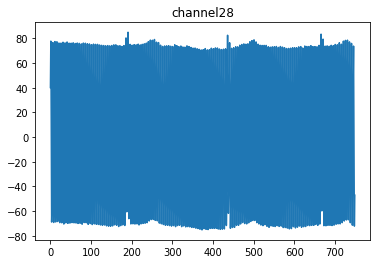

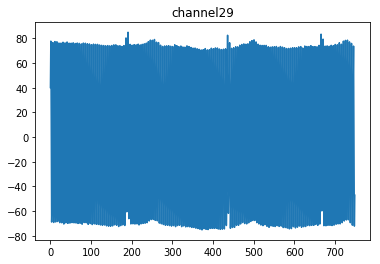

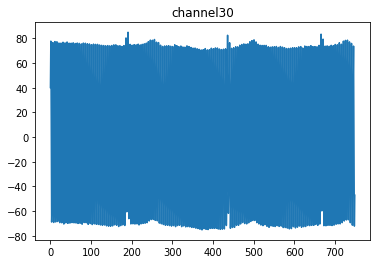

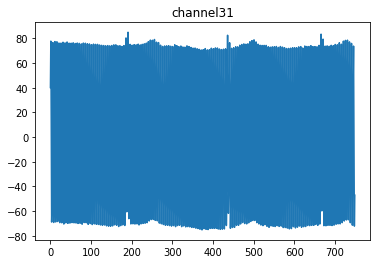

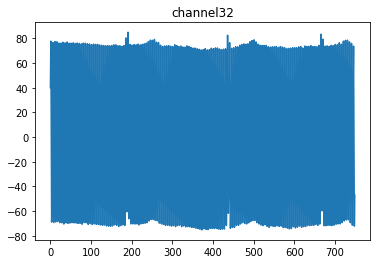

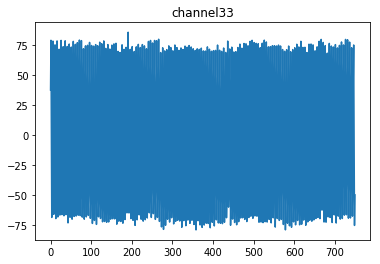

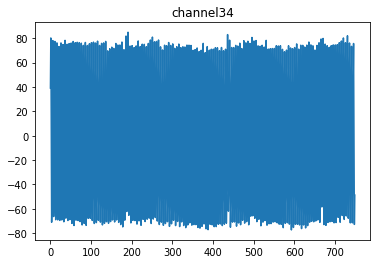

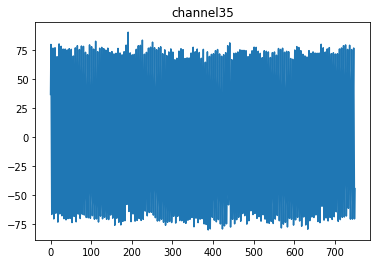

In [120]:
epoch = 4 

for ch in range(data_sf.shape[0]):
    plt.plot(data_sf[ch,:,epoch])
    plt.title('channel'+str(ch+1))
    plt.show()

In [121]:
# 4: map to frequencies 
data_fr,freqs = preproc.powerspectrum(data_sf,dim=1,fSample=fs)


In [122]:
# 5 : select the frequency bins we want
freqbands   =[8,10,28,30]
data_frB,freqIdx=preproc.selectbands(data_fr,dim=1,band=freqbands,bins=freqs)


In [123]:
# 6 : bad-trial removal
goodtr, badtr = preproc.outlierdetection(data_frB,dim=2)
data_goodtr = data_frB[:,:,goodtr]
y = y[goodtr]


In [124]:
# 7: train classifier, default is a linear-least-squares-classifier
clsfr = sklearn.linear_model.RidgeCV(store_cv_values=True)
X2d = np.reshape(data_goodtr,(-1,data_goodtr.shape[2])).T # sklearn needs data to be [nTrials x nFeatures]
clsfr.fit(X2d,y)
print("MSSE=%g"%np.mean(clsfr.cv_values_))


MSSE=1.70336


In [125]:
X2d.shape

(12, 2275)

In [126]:
# save the trained classifer
# N.B. Be sure to save enough to apply the classifier later!!
print('Saving clsfr to : %s'%(cname+'.pk'))
pickle.dump({'classifier':clsfr,'fSample':fs,'spatialfilter':spatialfilter,'freqbands':freqbands,'goodch':goodch,'valuedict':valuedict},open(cname+'.pk','wb'))


Saving clsfr to : clsfr.pk
